#### 다중분류 모델
- 손실 함수
- 성능평가

- [1] 모듈 로딩 및 데이터 준비 <hr>

In [2]:
# 모듈 로딩
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.data import Dataset

import numpy as np
import matplotlib.pyplot as plt

# Initializing libiomp5md.dll, but found libiomp5md.dll already initialized
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'


In [3]:
### 데이터 로딩 -> 내장 데이터셋 load_data()

(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [4]:
print(f'X_train : {X_train.shape}, y_train : {y_train.shape}')
print(f'X_test : {X_test.shape}, y_test : {y_test.shape}')

X_train : (60000, 28, 28), y_train : (60000,)
X_test : (10000, 28, 28), y_test : (10000,)


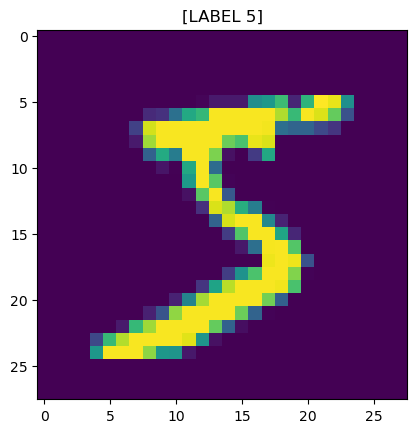

In [5]:
plt.imshow(X_train[0])
plt.title(f'[LABEL {y_train[0]}]')
plt.show()

- [2] 데이터 전처리 <hr>
    * 피쳐 : 타입, 정규화, 1D
    * 타겟 : 인코딩 -> One-Hot Encoding

In [6]:
## 피쳐 -> 타입, 정규화 (0.0 ~ 1.0), 2D -> 1D
## [1] ) ~ 255 -> 0.0 ~ 1.0
X_train = X_train/255
X_test = X_test/255

print(f'x_train_max : {X_train.max()} , x_train_min : {X_train.min()}, x_train_shape : {X_train.shape}, x_train_dtype : {X_train.dtype}')
print(f'x_test_max : {X_test.max()} , x_test_min : {X_test.min()}, x_test_shape : {X_test.shape}, x_test_dtype : {X_test.dtype}')

x_train_max : 1.0 , x_train_min : 0.0, x_train_shape : (60000, 28, 28), x_train_dtype : float64
x_test_max : 1.0 , x_test_min : 0.0, x_test_shape : (10000, 28, 28), x_test_dtype : float64


In [7]:
## [2] float64 -> float 32
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [8]:
## [3] 2D (28, 28) ==> 1D (28*28)
X_train = X_train.reshape(-1, 28*28)
X_test  = X_test.reshape(-1, 28*28)

print(f'X_train : {X_train.min()}, {X_train.max()} {X_train.shape}, {X_train.dtype}')
print(f'X_test  : {X_test.min()}, {X_test.max()} {X_test.shape}, {X_test.dtype}')

X_train : 0.0, 1.0 (60000, 784), float32
X_test  : 0.0, 1.0 (10000, 784), float32


In [9]:
## 라벨 ->  One-Hot Encoding
y_train = tf.one_hot(y_train, depth=10)
y_test = tf.one_hot(y_test, depth=10)

print(y_train[:3])

tf.Tensor(
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]], shape=(3, 10), dtype=float32)


[3] 모델 클래스 설계

In [10]:
## ----------------------------------------------------------------------------------
## 클래스이름 : MNISTModel
## ----------------------------------------------------------------------------------
## 입력층 : 입력/피쳐개수     784     출력/뉴런개수 300      활성화함수  ReLu
## 은닉층 : 입력/이전층뉴런수 300     출력/뉴런개수 100      활성화함수  ReLu
## 출력층 : 입력/이전층뉴런수 100     출력/라벨개수 10       활성화함수  회귀/이진/다중
## ----------------------------------------------------------------------------------
#class MNISTModel(tf.Module):
class MNISTModel():
    # 인스턴스 생성 메서드
    def __init__(self):
        #super().__init__()
        # 입력층
        self.in_w=tf.Variable(tf.random.normal([784,300]))
        self.in_b=tf.Variable(tf.random.normal([300]))

        # 은닉층
        self.hd_w=tf.Variable(tf.random.normal([300,100]))
        self.hd_b=tf.Variable(tf.random.normal([100]))

        # 출력층
        self.out_w=tf.Variable(tf.random.normal([100,10]))
        self.out_b=tf.Variable(tf.random.normal([10]))

    # 순방향 학습 메서드
    def __call__(self, data):
        # 입력층
        wbs=tf.matmul(data, self.in_w) + self.in_b
        output=tf.nn.relu(wbs)

        # 은닉층
        wbs=tf.matmul(output, self.hd_w) + self.hd_b
        output=tf.nn.relu(wbs)

        # 출력층 ==> Tensorflow에서 출력층의 가중합+절편 값 => 로짓(logits)
        logits=tf.matmul(output, self.out_w) + self.out_b

        return logits

[4] 학습관련 설정 <hr>
* 학습 횟수 즉, 에포크 개수
* 학습 데이터량 즉, 배치 사이즈
* 1에포크에 학습 횟수, 즉, 배치 개수
* 최적화 즉, 가중치와 절편 업데이트 간격으로 러닝레이트

In [11]:
#### 학습 관련 설정
LR= 0.001               # 일반적 0.0001 ~ 0.1
EPOCHS = 50             # 학습 데이터를 처음부터 끝까지는 몇 번 학습할지 횟수 설정
BATCH_SIZE = 600        # 한번에 학습할 데이터 양
DATA_NUMS = 60000       # 전체 학습용 데이터 개수
FEATURES = 784          # 피쳐 개수

In [12]:
#### 데이터셋 인스턴스 생성 ==> 지도학습 : 피쳐+라벨
TRAIN_DS = Dataset.from_tensor_slices((X_train, y_train))

#### 배치크기만큼 데이터 추출하는 데이터셋 인스턴스 생성
TRAIN_DS = TRAIN_DS.shuffle(DATA_NUMS).batch(BATCH_SIZE)

In [13]:
for data, label in TRAIN_DS:
    print(data.shape, label.shape)
    print(data[0], label[0])
    break

(600, 784) (600, 10)
tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0

[5] 학습 관련 함수들 <hr>
* 손실함수
* 성능평가 함수
* 학습함수

In [14]:
#### [1] 손실함수
@tf.function
def mcfLossFunc(y, logits):
    return tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=logits))

In [16]:
#### [2] 최적화 함수  => 모델의 층별로 존재하는 W, b를 업데이트 시켜주는 인스턴스
## - 최적화인스턴스 생성
## - 학습과정에서 새롭게 계산된 층별 W, b 값을 모델에 적용
optimizer = tf.keras.optimizers.Adam(LR)

In [17]:
#### [3] 학습관련 함수 => 모델 학습 + 손실 계산 + W,b 업데이트
@tf.function
def train(model, x, y):
    # 전방향 학습 기록
    with tf.GradientTape() as tape:
        # 학습 진행
        y_pred = model(x)
        # 손실 계산
        loss = mcfLossFunc(y, y_pred)

    # 손실에 대한 새로운 W, b 계산
    new_gradients=tape.gradient(loss, vars(model).values())

    # 새로운 W,b 업데이트 단, 새로운 가중치 값과 변수 쌍으로 묶어서 전달
    optimizer.apply_gradients( zip( new_gradients, vars(model).values() ))

In [18]:
#### [ 테스트 ]
m=MNISTModel()

# 인스턴스의 지역변수 키와 값 읽기 Dict 형태
m_vars=vars(m)

print(m_vars.keys())

dict_keys(['in_w', 'in_b', 'hd_w', 'hd_b', 'out_w', 'out_b'])


In [19]:
#### [4] 정확도 계산 함수 ==> accuracy
@tf.function
def accuracy(y_pred, y):

    correct = tf.equal( tf.argmax(y_pred, axis=1),  tf.argmax(y, axis=1))

    return tf.reduce_mean( tf.cast(correct, tf.float32) )

[6] 학습 진행

In [20]:
### 모델 인스턴스
MyModel=MNISTModel()

In [21]:
LOSS_HISTORY, ACC_HISTORY=[], []

for epoch in range(EPOCHS):

    total_loss =0

    # 배치크기만큼 학습
    for batch_x, batch_y in TRAIN_DS:

        # 학습 및 가중치, 절편 업데이트
        train(MyModel, batch_x, batch_y)

        # 가중치, 절편 업데이트된 값으로 Loss 계산
        current_loss = mcfLossFunc(batch_y, MyModel(batch_x))

        # 1에포크에 대한 Loss 계산 위해서 누적
        total_loss += current_loss

    # 1에포크에 대한 평균 Loss
    one_loss= total_loss/(DATA_NUMS//BATCH_SIZE)
    LOSS_HISTORY.append(one_loss)

    # 1에포크에 대한 정확도
    one_acc=accuracy(MyModel(X_test), y_test)

    print(f'[에포크 - {epoch}/{EPOCHS}] 평균 Loss : {one_loss}, 정확도 : {one_acc}' )

[에포크 - 0/50] 평균 Loss : 291.2976379394531, 정확도 : 0.6847000122070312
[에포크 - 1/50] 평균 Loss : 73.8895492553711, 정확도 : 0.8026000261306763
[에포크 - 2/50] 평균 Loss : 47.171234130859375, 정확도 : 0.8438000082969666
[에포크 - 3/50] 평균 Loss : 35.545230865478516, 정확도 : 0.8654000163078308
[에포크 - 4/50] 평균 Loss : 28.67670249938965, 정확도 : 0.8776999711990356
[에포크 - 5/50] 평균 Loss : 23.988405227661133, 정확도 : 0.8865000009536743
[에포크 - 6/50] 평균 Loss : 20.582014083862305, 정확도 : 0.8946999907493591
[에포크 - 7/50] 평균 Loss : 18.024188995361328, 정확도 : 0.899399995803833
[에포크 - 8/50] 평균 Loss : 15.9015531539917, 정확도 : 0.902899980545044
[에포크 - 9/50] 평균 Loss : 14.155799865722656, 정확도 : 0.9082000255584717
[에포크 - 10/50] 평균 Loss : 12.592058181762695, 정확도 : 0.9125999808311462
[에포크 - 11/50] 평균 Loss : 11.276815414428711, 정확도 : 0.9142000079154968
[에포크 - 12/50] 평균 Loss : 10.167778015136719, 정확도 : 0.9154000282287598
[에포크 - 13/50] 평균 Loss : 9.115449905395508, 정확도 : 0.9182000160217285
[에포크 - 14/50] 평균 Loss : 8.259273529052734, 정확도 : 0.92

[7] 테스트 이미지 <hr>
- 이미지 처리 관련 패키지 설치
    * %pip install opencv-python
    * %pip install pillow  ===> [확인] from PIL import Image

In [1]:
#%pip install pillow

Note: you may need to restart the kernel to use updated packages.


In [22]:
from PIL import Image

In [23]:
img=Image.open('my_two.jpg').convert('L')
img=img.resize((28, 28))

In [24]:
img_array=np.array(img)
type(img_array), img_array.shape

(numpy.ndarray, (28, 28))

In [25]:
img_array

array([[255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 212, 143, 111, 148,
        237, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255],
       [255, 255, 255, 255, 255, 255, 255, 244, 108,  83, 147, 186, 134,
         64, 180, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255],
       [25